# Julia Notebook for *Radial Duality Part II: Applications and Algorithms* #

### Benjamin Grimmer ###
___

This notebook follows along the ideas presented in [[1]](https://arxiv.org/abs/...). Below we present implementations of the algorithms considered in Section 2 thereof for quadratic programming, where our radial methods have far lower per iteration cost than traditional methods that maintain feasibility at each iteration. These classic methods all require a nontrivial subproblem related to the feasible region that we avoid.

**License**: Creative Commons License

This work is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/).

An MIT License for the underlying software is provided in the separate LICENSE file.

**Disclaimer**: We make no claim that the code below is optimized or the most efficient version possible. Instead our goal is to give a implementation. Speedups are certainly possible using optimized linear algebra packages and by taking advantage of sparsity and problem specific structure.

Any questions or feedback on this document can be sent to Ben Grimmer at *bdg79@cornell.edu*. 

[1] "Radial Duality Part II: Applications and Algorithms", https://arxiv.org/abs/2104.11185. Benjamin Grimmer. First posted April, 2021.

In [1]:
using LinearAlgebra
using Convex
using SCS
using Gurobi 
using PyPlot
using Dates

const GRB_ENV = Gurobi.Env()

function maxk(a, k)
    b = partialsortperm(a, 1:k, rev=true)
    return collect(zip(b, a[b]))
end;


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only


In [2]:
function radialPoint(x,u)
    return (x,1)./u
end;

# Quadratic Programming Tests

In [3]:
#Generating Random Test Data

dim = 100 #Variable dimension
n = 400 #Number of constraints

#Make a random objective with Q = PP^T
P = randn(dim,100)
Q = P*P'+10^-12*I(dim)
c = randn(dim)

#Make a random polyhedron
A = randn(n,dim)
b = ones(n)#abs.(randn(n));

In [4]:
#Solve the problem with SCS for comparison

function solvePrimal(Q,c,A,b)
    x_variable = Variable(dim)
    primal_problem = maximize(1 - 0.5*quadform(x_variable, Q) - c'*x_variable, A*x_variable <= b)
    solve!(primal_problem, () -> Gurobi.Optimizer(GRB_ENV, OutputFlag=0))
    return x_variable.value[:,1], primal_problem.optval
end
x_opt, primal_opt = solvePrimal(Q,c,A,b)
dual_opt = 1.0/primal_opt

x_opt, primal_opt

([0.15722867174827848, 0.06116468614302872, 0.002422399068240562, -0.05180103352341929, 0.11079609455458642, -0.014304647441999857, 0.03825081129080166, 0.058356499949048, 0.1160232578941963, -0.008666286899433577  …  0.004529399992726175, 0.02289596392267444, -0.03419292838600117, -0.059294407012315836, -0.08676687134649588, -0.038904485037168854, -0.05295391866099606, -0.02425220846107313, -0.040431569411247176, -0.010657155676251896], 3.4935740516490505)

In [5]:
#Primal Operations
function primalObj(x)
   return 1 - 0.5*norm(P'*x)^2 - c'*x 
end
function primalObj_gradient(x)
    return -1*(P*P'*x +c)
end
function primalObj_proj(x)
    #Solve QP
    x_local_variable = Variable(dim)
    projection_problem = minimize(sumsquares(x_local_variable - x), A*x_local_variable <= b)
    solve!(projection_problem, () -> Gurobi.Optimizer(GRB_ENV, OutputFlag=0))
    return x_local_variable.value[:,1]
end
function primalObj_linearize(x)
    grad = primalObj_gradient(x)
    #Solve LP
    x_local_variable = Variable(dim)
    fw_problem = maximize(dot(grad, x_local_variable), A*x_local_variable <= b)
    solve!(fw_problem, () -> Gurobi.Optimizer(GRB_ENV, OutputFlag=0))
    return x_local_variable.value[:,1]
end


#Radially Dual Operations
function dualObj(y)
    cy = c'*y
    yQy = norm(P'*y)^2
    obj = (cy+1+sqrt((cy+1)^2+2*yQy))/2
    cons = maximum(A*y./b)
    return max(obj, cons)
end
function dualObj_gradient(y)
    cy = c'*y
    yQy = norm(P'*y)^2
    obj = (cy+1+sqrt((cy+1)^2+2*yQy))/2
    cons = maximum(A*y./b)
    
    if obj > cons
        return 0.5*c + 0.25/sqrt((cy+1)^2+2*yQy)*(2*(cy+1)*c + 4*P*(P'*y))
    else
        i = findmax(A*y./b)[2]
        return A[i,:]./b[i]
    end
end
eta=0.0001
function smoothedDualObj(y, eta)
    cy = c'*y
    yQy = norm(P'*y)^2
    obj = (cy+1+sqrt((cy+1)^2+2*yQy))/2
    cons = maximum(A*y./b)
    baseline = max(obj, cons)

    r=0
    r +=exp((obj - baseline)/eta)
    for i in 1:n
        r += exp((A[i,:]'*y/b[i] - baseline)/eta)
    end    
    return baseline + eta*log(r) 
end
function smoothedDualObj_gradient(y, eta)
    cy = c'*y
    yQy = norm(P'*y)^2
    obj = (cy+1+sqrt((cy+1)^2+2*yQy))/2
    cons = maximum(A*y./b)
    baseline = max(obj, cons)

    r=0
    r +=exp((obj - baseline)/eta)
    for i in 1:n
        r += exp((A[i,:]'*y/b[i] - baseline)/eta)
    end  
    
    grad = zeros(dim)
    grad += (0.5*c + 0.25/sqrt((cy+1)^2+2*yQy)*(2*(cy+1)*c + 4*P*(P'*y)))*exp((obj - baseline)/eta)/r
    for i in 1:length(b)
        grad += A[i,:]./b[i]*exp((A[i,:]'*y/b[i] - baseline)/eta)/r
    end    
    return grad
end;

In [6]:
T=1000

topEigvalQ = eigvals(Q)[dim]
function projectedGD(x, seconds, samples)
    ret = zeros(samples)
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    i=1
    while ti < tn
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ret[timestep] = primalObj(x)
        grad = primalObj_gradient(x)
        x = primalObj_proj(x + grad/topEigvalQ)
        ti = round(Int64, time() * 1000)
        i=i+1
    end
    return (x,primalObj(x)), ret, i-1
end
function projectedAccel(x, seconds, samples)
    ret = zeros(samples)
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    i=1
    x_prev=x
    while ti < tn
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ret[timestep] = primalObj(x)
        x_mid = x + (i-2)/(i+1)*(x - x_prev)
        grad = primalObj_gradient(x_mid)
        x_prev=x
        x = primalObj_proj(x_mid + grad/topEigvalQ)
        ti = round(Int64, time() * 1000)
        i=i+1
    end
    return (x,primalObj(x)), ret, i-1
end
function FW(x, seconds, samples)
    ret = zeros(samples)
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    i=1
    while ti < tn
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ret[timestep] = primalObj(x)
        xLP = primalObj_linearize(x)
        dir = xLP-x
        gap = primalObj_gradient(x)'*dir    
        stepsize = min(gap/norm(P'*dir)^2,1)       
        x = x+stepsize*dir
        ti = round(Int64, time() * 1000)
        i=i+1
    end
    return (x,primalObj(x)), ret, i-1
end

function radialSubgradientMethod(x, seconds, samples)
    ret = zeros(samples)
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    i=1
    u = primalObj(x)
    (y,v) = radialPoint(x,u)
    cy = 0
    Py=zeros(10)
    yQy = 0
    Ayb = zeros(n)
    obj = 0
    cons = 0
    dualObjValue=0
    grad=zeros(dim)
    while ti < tn
        cy = c'*y
        Py = P'*y
        yQy = norm(Py)^2
        obj = (cy+1+sqrt((cy+1)^2+2*yQy))/2
        Ayb = A*y./b
        cons = maximum(Ayb)
        dualObjValue=max(obj,cons)
        
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ret[timestep] = 1.0/dualObjValue

        if obj > cons
            grad = 0.5*c + 0.25/sqrt((cy+1)^2+2*yQy)*(2*(cy+1)*c + 4*P*Py)
        else
            index = findmax(Ayb)[2]
            grad = A[index,:]./b[index]
        end
        polyak = (dualObjValue-dual_opt)/norm(grad)^2
        y +=-1*polyak*grad
        ti = round(Int64, time() * 1000)
        i=i+1
    end
    v = dualObj(y)
    return radialPoint(y,v), ret, i-1
end

function radialSmoothedMethod_accel(x, eta, tune, seconds, samples)
    ret = zeros(samples)
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0 
    i=1
    u = primalObj(x)
    (y,v) = radialPoint(x,u)
    y_prev= y
    y_mid = y
    L2 = norm(c)^2
    for i in 1:n
        if norm(A[i,:]/b[i])^2 > L2 L2 = norm(A[i,:]/b[i])^2 end
    end
    L= tune*L2/eta
    cy = 0
    Py=zeros(10)
    yQy = 0
    Ayb = zeros(n)
    obj = 0
    cons = 0
    dualObjValue=0
    r = 0
    grad=zeros(dim)
    while ti < tn
        y_mid = y + (i-2)/(i+1)*(y - y_prev)

        cy = c'*y_mid
        Py = P'*y_mid
        yQy = norm(Py)^2
        obj = (cy+1+sqrt((cy+1)^2+2*yQy))/2
        Ayb = A*y_mid./b
        cons = maximum(Ayb)
        baseline = max(obj, cons)
        
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ret[timestep] = 1.0/baseline
        
        r=0
        grad = 0*grad
        value = 2.718281828459045^((obj - baseline)/eta)
        r += value
        grad += (0.5*c + 0.25/sqrt((cy+1)^2+2*yQy)*(2*(cy+1)*c + 4*P*Py))*value
        for j in partialsortperm(Ayb, 1:n, rev=true)
            if (Ayb[j] - baseline)/eta<-50 break end
            value = 2.718281828459045^((Ayb[j] - baseline)/eta)
            r += value
            grad += A[j,:]./b[j]*value
        end
        y_prev = y
        y = y_mid - grad/(r*L)
        ti = round(Int64, time() * 1000)
        i=i+1
    end 
    v = dualObj(y)
    return radialPoint(y,v), ret, i-1
end

radialSmoothedMethod_accel (generic function with 1 method)

In [7]:
function cleanData(data)
    for i in 2:length(data)
        data[i] = max(data[i-1], data[i])
    end
    return data
end

experiment_time = 30 #3600*0.5
experiment_samples = 100 #200;

In [8]:
(x,u), gd_data, gd_iter = @time projectedGD(zeros(dim), experiment_time, experiment_samples)
gd_data=cleanData(gd_data)
print(gd_iter, " iterations of Gradient Descent in the timelimit")

 30.217491 seconds (28.00 M allocations: 3.229 GiB, 1.87% gc time)
253 iterations of Gradient Descent in the timelimit

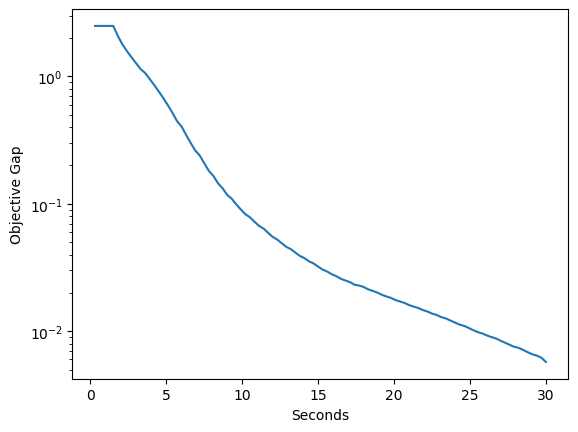

In [9]:
gd_time = experiment_time
semilogy((gd_time/length(gd_data)).*(1:length(gd_data)), primal_opt .- gd_data, label="Projected GD")
#ylim(0.0001,100)
xlabel("Seconds")
ylabel("Objective Gap");

In [10]:
(x,u), accel_data, accel_iter = @time projectedAccel(zeros(dim), experiment_time, experiment_samples)
accel_data=cleanData(accel_data)
print(accel_iter, " iterations of the Accelerated Method in the timelimit")

 30.161491 seconds (30.38 M allocations: 3.709 GiB, 2.03% gc time)
303 iterations of the Accelerated Method in the timelimit

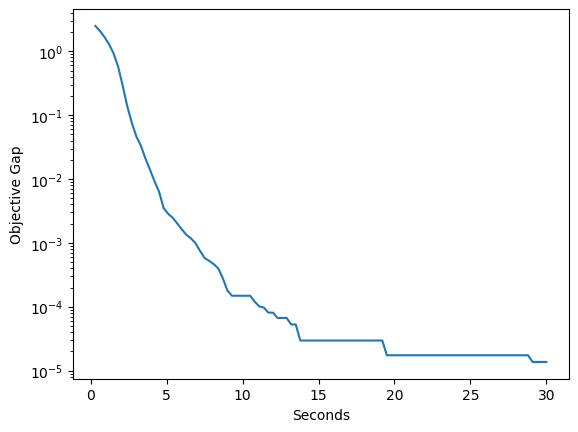

In [11]:
accel_time = experiment_time
semilogy((accel_time/length(accel_data)).*(1:length(accel_data)), primal_opt .- accel_data, label="Projected GD")
#ylim(0.0001,100)
xlabel("Seconds")
ylabel("Objective Gap");

In [12]:
(x,u), fw_data, fw_iter = @time FW(zeros(dim), experiment_time, experiment_samples)
cleanData(fw_data)
print(fw_iter, " iterations of Frank-Wolfe in the timelimit")

 30.087523 seconds (43.17 M allocations: 4.931 GiB, 2.64% gc time)
377 iterations of Frank-Wolfe in the timelimit

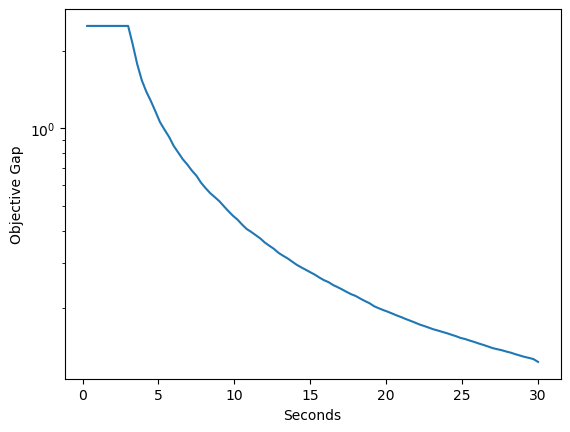

In [13]:
fw_time = experiment_time
semilogy((fw_time/length(fw_data)).*(1:length(fw_data)), primal_opt .- fw_data, label="Frank Wolfe")
#ylim(0.0001,100)
xlabel("Seconds")
ylabel("Objective Gap");

In [14]:
(x,u), rsg_data, rsg_iter = @time radialSubgradientMethod(zeros(dim), experiment_time, experiment_samples)
cleanData(rsg_data)
print(rsg_iter, " iterations of the Radial Subgradient Method in the timelimit")

 30.287093 seconds (6.54 M allocations: 2.572 GiB, 1.38% gc time)
144944 iterations of the Radial Subgradient Method in the timelimit

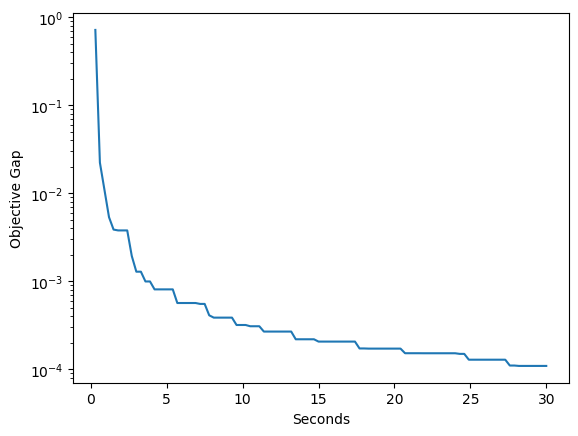

In [15]:
rsg_time = experiment_time
semilogy((rsg_time/length(rsg_data)).*(1:length(rsg_data)), (primal_opt .- rsg_data)./primal_opt, label="Radial Subgradient Method")
#ylim(0.0001,100)
xlabel("Seconds")
ylabel("Objective Gap");

In [16]:
(x,u), raccel_data, raccel_iter = @time radialSmoothedMethod_accel(zeros(dim), 0.000001, 0.1, experiment_time, experiment_samples)
cleanData(raccel_data)
print(raccel_iter, " iterations of the Radial Smoothing Method in the timelimit")

 30.320451 seconds (31.69 M allocations: 10.766 GiB, 5.75% gc time)
61214 iterations of the Radial Smoothing Method in the timelimit

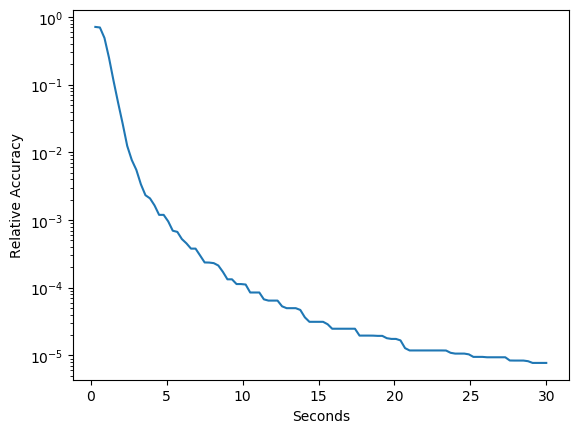

In [17]:
raccel_time = experiment_time
semilogy((raccel_time/length(raccel_data)).*(1:length(raccel_data)), (primal_opt .- raccel_data)./primal_opt, label="Radial Smoothing")
xlabel("Seconds")
ylabel("Relative Accuracy");

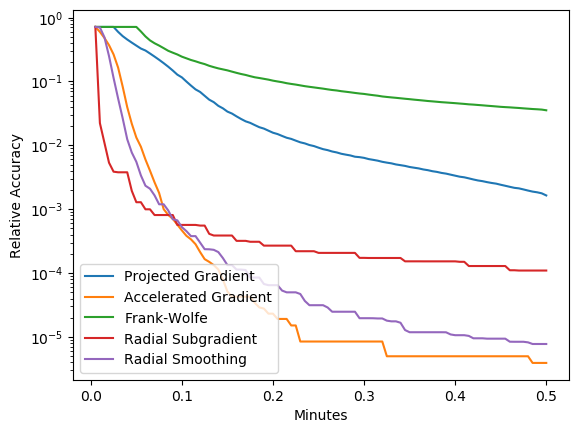

In [18]:
semilogy((gd_time/(60*length(gd_data))).*(1:length(gd_data)), (primal_opt .- gd_data)./primal_opt, label="Projected Gradient")
semilogy((accel_time/(60*length(accel_data))).*(1:length(accel_data)), (primal_opt .- accel_data)./primal_opt, label="Accelerated Gradient")
semilogy((fw_time/(60*length(fw_data))).*(1:length(fw_data)), (primal_opt .- fw_data)./primal_opt, label="Frank-Wolfe")
semilogy((rsg_time/(60*length(rsg_data))).*(1:length(rsg_data)), (primal_opt .- rsg_data)./primal_opt, label="Radial Subgradient")
semilogy((raccel_time/(60*length(raccel_data))).*(1:length(raccel_data)), (primal_opt .- raccel_data)./primal_opt, label="Radial Smoothing")
legend()
#xlim(-5,1350)
#ylim(0.007,1.15)
xlabel("Minutes")
ylabel("Relative Accuracy");